In [1]:
import pandas as pd
pd.options.display.max_columns=999
pd.options.display.max_rows=999
import pandas_profiling
from collections import Counter, defaultdict
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%reload_ext autoreload
%autoreload 2
from tqdm import tqdm_notebook, trange
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from glob import glob
from itertools import chain
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_curve
import datetime
import os

In [2]:
review_df = pd.read_csv('src/amzn_fake_review_star_correct_302066.csv')

In [3]:
review_df.shape

(302066, 5)

In [4]:
review_df.head()

,review_id,en_segment,th_segment,correct,review_star
0,1-333090,Good quality product at reasonable price.,สินค้าคุณภาพดีในราคาที่เหมาะสม,1.0,4.0
1,1-57783,They do NOT last more than 10 bottles.,พวกเขาไม่เกิน 10 ขวด,0.0,1.0
2,1-319174,If you like post-apocalyptic fiction with a tw...,ถ้าคุณชอบนิยายหลังเลิกเรียนด้วยการบิดนี่คือมัน,0.0,4.0
3,1-425331,Was a little worried when purchasing due to so...,รู้สึกกังวลเล็กน้อยเมื่อซื้อเนื่องจากรีวิวบางอ...,0.0,4.0
4,1-134583,I had heard from relatives who have read this ...,ฉันได้ยินจากญาติที่อ่านหนังสือเล่มนี้ว่าพ่อแม่...,1.0,2.0


In [11]:
# show random en_segment / th_segment
rand_idx = np.random.randint(len(review_df))
print('comment: {}\nis_correct: {}\nreview star:{}'.format(review_df.iloc[rand_idx]['th_segment'],
      review_df.iloc[rand_idx]['correct'],
      review_df.iloc[rand_idx]['review_star']))

comment: ฉันเคยมีราคาถูกสักพัก แต่นี่ยอดเยี่ยมกว่ามากมันถือบัตรเครดิตได้เกือบมากและสิ่งนั้นก็แย่มากสรุปแล้วมันช่วยปกป้องโทรศัพท์ของฉันได้เป็นอย่างดีและก็ดูเท่ด้วย :) แนะนำโดยฉันเวลาจัดส่งจากจีนใช้เวลาประมาณ 2 สัปดาห์ดังนั้นหากคุณต้องการให้สินค้าของคุณไม่ได้สั่งอย่างรวดเร็วเว้นแต่จะมีการจัดส่งแบบเร่งด่วน (: ลูกค้าที่มีความสุข:) แก้ไข: 8 มิถุนายน 2012 - มันยังทำงานได้ค่อนข้างดีหลังจาก 6 เดือน
is_correct: 0.0
review star:5.0


In [12]:
review_df.isna().sum()

review_id      0
en_segment     0
th_segment     0
correct        0
review_star    0
dtype: int64

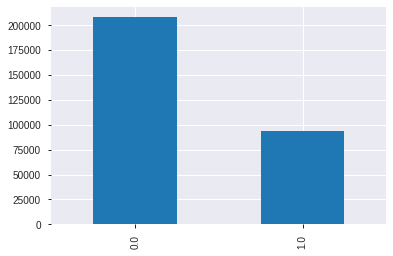

In [13]:
review_df['correct'].value_counts().plot(kind='bar')

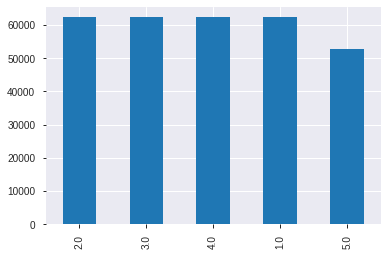

In [14]:
review_df['review_star'].value_counts().plot(kind='bar')

In [18]:
from pythainlp.ulmfit import *

Corpus: wiki_lm_lstm
- Downloading: wiki_lm_lstm 0.32


100%|██████████| 1050919089/1050919089 [00:30<00:00, 34064861.62it/s]


Corpus: wiki_itos_lstm
- Downloading: wiki_itos_lstm 0.32


100%|██████████| 1530484/1530484 [00:00<00:00, 11983085.92it/s]


In [ ]:
review_df["processed"] = review_df['th_segment'].map(lambda x: "|".join(process_thai(x)))
review_df["wc"] = review_df['processed'].map(lambda x: len(x.split("|")))
review_df["uwc"] = review_df['processed'].map(lambda x: len(set(x.split("|"))))

In [3]:
# save tokenized review
# os.makedirs('tmp',exist_ok=True)
# review_df.to_csv('tmp/review_df_check-point-1.csv',index=False)

review_df = pd.read_csv('tmp/review_df_check-point-1.csv')

# Train/valid split

In [4]:
train_df, valid_df = train_test_split(review_df, test_size=0.20, random_state=1)
train_df = train_df.reset_index(drop=True)

# further split validation to validation & test
valid_df, test_df = train_test_split(valid_df, test_size=0.50, random_state=11)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.shape, valid_df.shape, test_df.shape

((241652, 8), (30207, 8), (30207, 8))

In [5]:
# prevalence
train_df["correct"].value_counts(normalize=True)

0.0    0.689533
1.0    0.310467
Name: correct, dtype: float64

In [6]:
# prevalence
valid_df["correct"].value_counts(normalize=True)

0.0    0.682822
1.0    0.317178
Name: correct, dtype: float64

In [8]:
# create separate train + valid data called all df
all_df = pd.concat([train_df,valid_df],axis=0)
all_df.reset_index(drop=True, inplace=True)

In [9]:
all_df.to_feather('tmp/all_df')

In [10]:
all_df.shape

(271859, 8)

In [11]:
all_df.head()

,review_id,en_segment,th_segment,correct,review_star,processed,wc,uwc
0,1-105256,The writing seems stilted and the characters a...,ดูเหมือนว่าการเขียนจะโอ้อวดและตัวละครไม่น่าสนใ...,0.0,2.0,ดูเหมือนว่า|การเขียน|จะ|โอ้อวด|และ|ตัวละคร|ไม่...,88,70
1,2-38709,We bought these for our 3 year old son to acco...,เราซื้อสิ่งเหล่านี้ให้กับลูกชายวัย 3 ขวบของเรา...,0.0,4.0,เรา|ซื้อ|สิ่ง|เหล่านี้|ให้|กับ|ลูกชาย|วัย|3|ขว...,37,32
2,1-399475,"this movie was fun and funny, I loved it from ...",หนังเรื่องนี้สนุกและตลกมากฉันชอบมันตั้งแต่ต้นจ...,0.0,4.0,หนัง|เรื่อง|นี้|สนุก|และ|ตลก|มาก|ฉัน|ชอบ|มัน|ต...,24,23
3,2-31276,"The book has a lot of helpful tips, but is lac...",หนังสือเล่มนี้มีเคล็ดลับที่เป็นประโยชน์มากมาย ...,0.0,2.0,หนังสือ|เล่ม|นี้|มี|เคล็ดลับ|ที่|เป็นประโยชน์|...,73,64
4,2-11047,I like the author however this book did was no...,ฉันชอบผู้แต่ง แต่หนังสือเล่มนี้ไม่ได้ขึ้นอยู่ก...,0.0,1.0,ฉัน|ชอบ|ผู้แต่ง|แต่|หนังสือ|เล่ม|นี้|ไม่ได้|ขึ...,39,33


# Logistic regression

In [4]:
#dependent variables
y_train = train_df["correct"]
y_valid = valid_df["correct"]

In [5]:
#text faetures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
tfidf = TfidfVectorizer(tokenizer=lambda x:x.split('|'), ngram_range=(1,2), max_features=25_000, sublinear_tf=True)
tfidf.fit(pd.concat([train_df,valid_df],axis=0)["processed"])
text_train = tfidf.transform(train_df["processed"])
text_valid = tfidf.transform(valid_df["processed"])
text_test = tfidf.transform(test_df["processed"])
text_train.shape, text_valid.shape

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=20000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function <lambda> at 0x7fc7639590e0>, use_idf=True,
                vocabulary=None)

((241652, 20000), (30207, 20000))

In [7]:
#word count and unique word counts; actually might not be so useful
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(pd.concat([train_df,valid_df],axis=0)[["wc","uwc"]].astype(float))
print(scaler.mean_, scaler.var_)
num_train = scaler.transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler.transform(valid_df[["wc","uwc"]].astype(float))
num_test = scaler.transform(test_df[["wc","uwc"]].astype(float))
num_train.shape, num_valid.shape

StandardScaler(copy=True, with_mean=True, with_std=True)

[55.35855351 46.01925263] [651.70895073 381.49864169]


((241652, 2), (30207, 2))

In [ ]:
#concatenate text and word count features
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
X_test = np.concatenate([num_test,text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

In [12]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

LogisticRegression(C=2.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

0.7160450231736923

In [14]:
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(X_valid)
probs_df["correct"] = valid_df['correct']
probs_df["th_segment"] = valid_df['th_segment']
probs_df["processed"] = valid_df['processed']
probs_df["wc"] = valid_df['wc']
probs_df["uwc"] = valid_df['uwc']
probs_df["hit"] = (probs_df['preds']==probs_df['correct'])
probs_df.to_csv("tmp/probs_df_linear.csv", index=False)

In [15]:
probs_df.head()

,0.0,1.0,preds,correct,th_segment,processed,wc,uwc,hit
0,0.807132,0.192868,0.0,1.0,เหตุผลเดียวที่ทำให้มันได้รับสามดาวก็เพราะว่ามั...,เหตุผล|เดียว|ที่|ทำให้|มัน|ได้รับ|สาม|ดาว|ก็เพ...,50,43,False
1,0.665240,0.334760,0.0,1.0,ซื้อและลองสิ่งนี้เมื่อหน่วยเก่าของฉันล้มเหลว (...,ซื้อ|และ|ลอง|สิ่ง|นี้|เมื่อ|หน่วย|เก่า|ของ|ฉัน...,28,28,False
2,0.272429,0.727571,1.0,0.0,ฉันดีใจที่ฉันไม่ได้จ่ายอะไรเลย,ฉัน|ดีใจ|ที่|ฉัน|ไม่ได้|จ่าย|อะไร|เลย,8,7,False
3,0.864635,0.135365,0.0,0.0,ไม่ชอบสไตล์การเขียนของผู้เขียนรู้สึกว่ามันสื่อ...,ไม่|ชอบ|สไตล์|การเขียน|ของ|ผู้เขียน|รู้สึก|ว่า...,83,71,True
4,0.915618,0.084382,0.0,0.0,ฉันมีสุนัขตัวใหญ่มาก - £ 12 และปลอกคอนี้จะไม่พ...,ฉัน|มี|สุนัข|ตัว|ใหญ่|มาก|-|£|12|และ|ปลอกคอ|นี...,73,55,True


0.7160450231736923


Text(30.5, 0.5, 'Actual')

Text(0.5, 12.5, 'Predicted')

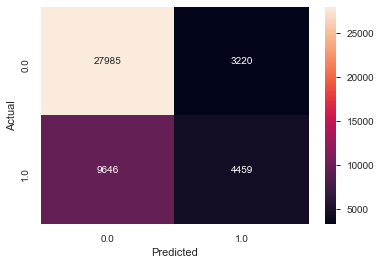

In [17]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(probs_df['correct'],probs_df['preds'])
print(model.score(X_valid,y_valid))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## ULMFit

In [10]:
from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback
from pythainlp.ulmfit import *

In [12]:
os.makedirs('output', exist_ok=True)
model_path = "output/"
# review_df = pd.read_csv('src/amzn_fake_review_star_correct_302066.csv')
# train_df, valid_df = train_test_split(review_df, test_size=0.15)

In [13]:
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=2)]

data_lm = (TextList.from_df(all_df, model_path, cols="th_segment", processor=processor)
    .split_by_rand_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=48))
data_lm.sanity_check()

In [14]:
data_lm.save('amazon_fake_review_lm.pkl')

In [15]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (269141 items)
x: LMTextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที

In [16]:
print("training frozen")
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy,time
0,4.089589,3.851502,0.289732,23:10


In [17]:
#train unfrozen
print("training unfrozen")
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8, 0.7))

training unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,3.706123,3.546770,0.326780,23:46
1,3.563003,3.408280,0.344232,23:44
2,3.476734,3.334823,0.352923,23:44
3,3.405852,3.290928,0.357964,23:46
4,3.364645,3.279840,0.359816,23:45


In [18]:
learn.save_encoder("amazon_thai_review_enc")

# Train classifier

In [20]:
#lm data
data_lm = load_data(model_path, "amazon_fake_review_lm.pkl")
data_lm.sanity_check()

#classification data
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=20)]

data_cls = (ItemLists(model_path,train=TextList.from_df(train_df, model_path, cols=["th_segment"], processor=processor),
                     valid=TextList.from_df(valid_df, model_path, cols=["th_segment"], processor=processor))
    .label_from_df("correct")
    .databunch(bs=50)
    )
data_cls.sanity_check()
print(len(data_cls.vocab.itos))

27720


In [38]:
#model
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
#load pretrained finetuned model
learn.load_encoder("amazon_thai_review_enc")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (241652 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

In [39]:
#train unfrozen
learn.freeze_to(-1)
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 4.37E-02


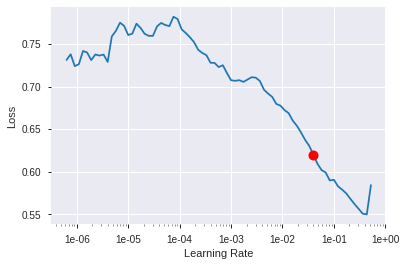

In [40]:
learn.recorder.plot(suggestion=True)

In [41]:
learn.load_encoder("amazon_thai_review_enc")
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2)
learn.save_encoder("amazon_thai_review_enc-1")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (241652 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

epoch,train_loss,valid_loss,time
0,0.206889,0.199349,23:00


In [42]:
learn.load_encoder("amazon_thai_review_enc-1")
learn.freeze_to(-2)
learn.lr_find()

RNNLearner(data=TextClasDataBunch;

Train: LabelList (241652 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06
Min loss divided by 10: 7.59E-08


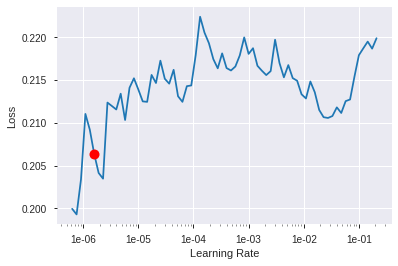

In [43]:
learn.recorder.plot(suggestion=True)

In [44]:
learn.load_encoder("amazon_thai_review_enc-1")
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-6 / (2.6 ** 4), 1e-6))
learn.save_encoder("amazon_thai_review_enc-2")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (241652 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

epoch,train_loss,valid_loss,time
0,0.207407,0.199462,23:05


In [45]:
learn.load_encoder("amazon_thai_review_enc-2")
learn.freeze_to(-3)
learn.lr_find()

RNNLearner(data=TextClasDataBunch;

Train: LabelList (241652 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-06
Min loss divided by 10: 7.59E-08


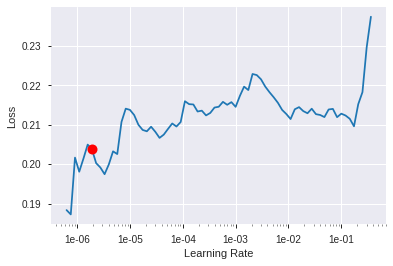

In [46]:
learn.recorder.plot(suggestion=True)

In [47]:
learn.load_encoder("amazon_thai_review_enc-2")
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(2e-6 / (2.6 ** 4), 2e-6))
learn.save_encoder("amazon_thai_review_enc-3")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (241652 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

epoch,train_loss,valid_loss,time
0,0.209430,0.199060,21:14


In [48]:
learn.load_encoder("amazon_thai_review_enc-3")
learn.unfreeze()
learn.lr_find()

RNNLearner(data=TextClasDataBunch;

Train: LabelList (241652 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.32E-07


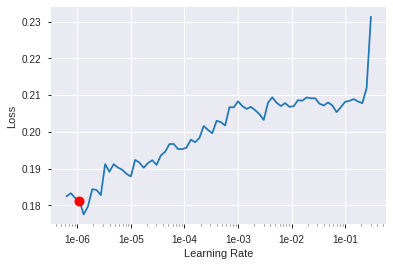

In [49]:
learn.recorder.plot(suggestion=True)

In [50]:
learn.load_encoder("amazon_thai_review_enc-3")
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6 / (2.6 ** 4), 1e-6),
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestmodel')])

RNNLearner(data=TextClasDataBunch;

Train: LabelList (241652 items)
x: TextList
xxbos   ดูเหมือนว่า การเขียน จะ โอ้อวด และ ตัวละคร ไม่ น่าสนใจ พอ ที่จะ ดึง ฉัน เข้ามา มี หลาย คน ที่ เป็น แบบแผน เช่น   &' nerd &'   หรือ   &' jerk &' และ พล็อต เรื่อง ต่าง   ๆ   ดูเหมือน จะ ถูก วางแผน เพื่อ ความ สะดวกสบาย ของ ฉัน เรื่องราว ลาก ไป ใน สถานที่ โดยเฉพาะอย่างยิ่ง ใน บางครั้ง อาจ เป็น เพราะ ฉัน เคยชิน กับ นวนิยาย อเมริกัน สมัยใหม่ ซึ่ง มีแนวโน้ม ที่จะ เคลื่อนไหว ได้ เร็ว ขึ้น โดย ไม่ต้อง สร้าง โลก ที่ ซับซ้อน ในทางกลับกัน ตัวละคร เหล่านี้ มี ความลึก ไม่ มาก เมื่อ เทียบ กับ ที่ ฉัน มักจะ พบ   /   พบ เจอ,xxbos   เรา ซื้อ สิ่ง เหล่านี้ ให้ กับ ลูกชาย วัย   3   ขวบ ของ เรา เพื่อ ติดตาม   kindle   fire   ใหม่ ของ เขา เพราะ เรา คิด ว่า เขา จะ กลัว ที่จะ ใช้ มัน   แต่ พวกเขา กลับ กลายเป็น ว่า ถูกต้อง ง่าย นิดเดียว,xxbos   หนัง เรื่อง นี้ สนุก และ ตลก มาก ฉัน ชอบ มัน ตั้ง แต่ต้นจนจบ ภาพยนตร์ คืน วันที่ ดี เหมาะสำหรับ ผู้ ที่ ไม่ ชอบ อารมณ์ขัน หรือ ความรุนแรง,xxbos   หนังสือ เล่ม นี้ มี เคล็ดลับ ที่ เป็

epoch,train_loss,valid_loss,time
0,0.213511,0.199746,23:31
1,0.205616,0.199260,22:17
2,0.204030,0.199670,20:39
3,0.208544,0.199196,20:46
4,0.206184,0.199325,20:24
5,0.206489,0.200255,23:40
6,0.203239,0.199223,21:16
7,0.211367,0.198830,20:42
8,0.211338,0.198910,20:33
9,0.201529,0.199328,22:42


/opt/conda/lib/python3.7/site-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `accuracy` which is not available. Available metrics are: train_loss, valid_loss
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')
/opt/conda/lib/python3.7/site-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `accuracy` which is not available. Available metrics are: train_loss, valid_loss
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')
/opt/conda/lib/python3.7/site-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `accuracy` which is not

FileNotFoundError: [Errno 2] No such file or directory: 'output/models/bestmodel.pth'

In [52]:
learn.save_encoder("amazon_thai_review_enc-4")

In [86]:
#get predictions
probs, y_true, loss = learn.get_preds(ds_type = DatasetType.Valid, ordered=True, with_loss=True)
y_true = y_true.numpy()
preds = (probs.numpy()>.5).astype(np.float)
loss = loss.numpy()

In [93]:
to_df = np.concatenate([y_true[:,None],preds,loss[:,None],probs.numpy()],1)
probs_df = pd.DataFrame(to_df)
probs_df.columns = ['true','pred','loss','prob']
probs_df["hit"] = (probs_df['true'] == probs_df['pred'])
probs_df["text"] = valid_df['th_segment']
(y_true==preds).mean()

0.6490137079542622